**Libraries**

In [1]:
!pip install mlflow

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import keras
from keras.models import Sequential, save_model
from keras.layers import Conv1D, Dense, Dropout, Reshape
from keras.layers import Flatten, TimeDistributed
from keras.layers import MaxPooling1D
from keras.callbacks import EarlyStopping
import mlflow
from keras.models import load_model
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Explanatory Data Analysis and Feature Engineering

In [2]:
# Reading data
df_train = pd.read_csv('mitbih_train.csv', header=None)
df_test = pd.read_csv('mitbih_test.csv', header=None)

print("The shape of train dataset : ",df_train.shape)
print("The shape of test dataset : ",df_test.shape)

The shape of train dataset :  (87554, 188)
The shape of test dataset :  (21892, 188)


## Statistical Analysis

In [ ]:
# Here is the statistical description for dataset (only train set)
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000




1.   The information presented in the table clearly demonstrates that the data for all features falls within the range of 0 to 1. This suggests that the data has been normalized, thus making additional scaling unnecessary for model building.


2.   A further insight gained from our statistical analysis is that the data for each record displays a right-skew. This inference is supported by the observed trend of declining feature means as the number of features increases.



## Checking missing values

In [7]:
miss_val_train = pd.DataFrame(df_train.describe())
miss_val_test = pd.DataFrame(df_test.describe())

print(f'number of missing values in the training dataset: {miss_val_train.isna().sum().sum()}')
print(f'number of missing values in the test dataset: {miss_val_test.isna().sum().sum()}')

number of missing values in the training dataset: 0
number of missing values in the test dataset: 0


Train and test Datasets have no missing values.

In order to answer your question, several methods are existed to impute the dataset:

1. **Removing missing values:** 
This method is used when a. number of missing values are not high. b. the feature is not meaningful for our analysis. 

2. **Impute with Mean:** It is used for regression-based feature.

3. **Impute with median:** It is used for regression-based feature and it is good for dealing with outliers.

4. **Impute with mode:** It is used for categorical features.

5. **Impute with machine learning and deep learning models :** works well with categorical and numerical values (KNN – ANN). It is accurate but complex 
6. **Multiple Imputation by Chained Equations (MICE)**: regression-based feature imputation

## Signal Visualization

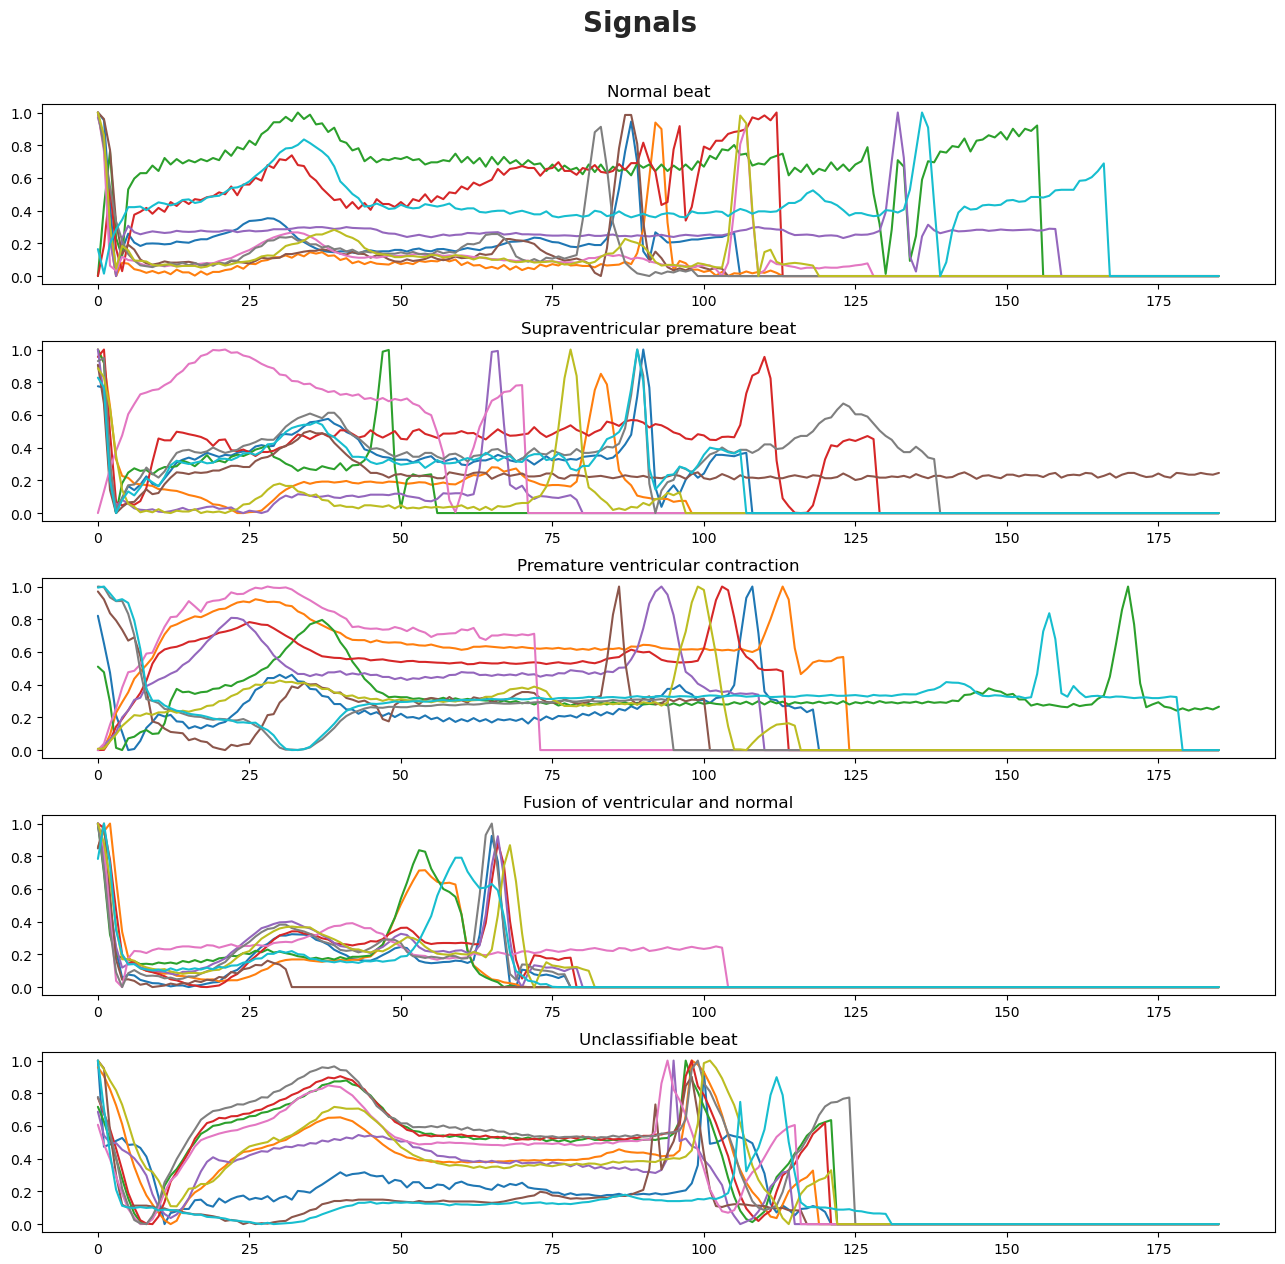

In [6]:
class EcgSignalPlotter:
    def __init__(self, train_data, sample_size=10):
        self.train_data = train_data
        self.sample_size = sample_size
        self.label_dict = {
            0: "Normal beat",
            1: "Supraventricular premature beat",
            2: "Premature ventricular contraction",
            3: "Fusion of ventricular and normal",
            4: "Unclassifiable beat"
        }
        self.fig, self.axs = plt.subplots(5,1, figsize=(13, 12))

    def get_samples(self):
        self.samples = [self.train_data.loc[self.train_data[187] == cls].sample(self.sample_size) for cls in range(5)]
        self.titles = [self.label_dict[cls] for cls in range(5)]
        
    def plot_ecg_signals(self):
        with plt.style.context("seaborn-white"):
            for i in range(5):
                ax = self.axs.flat[i]
                ax.plot(self.samples[i].values[:,:-2].transpose())
                ax.set_title(self.titles[i])
            plt.tight_layout()
            plt.suptitle("Signals", fontsize=20, y=1.05, weight="bold")
            
ecg_plotter = EcgSignalPlotter(df_train)
ecg_plotter.get_samples()
ecg_plotter.plot_ecg_signals()

The charts displayed above depict the progression of ECG signal amplitudes over time. The interpretations are based on the demonstration of 10 samples from each class. There appears to be a similar pattern in the last two classes. However, for other classes, finding a clear pattern presents more of a challenge. 

It should be noted that in some sections of the charts, the presence of time dependency within the class is evident. So, when it comes to the modeling aspect, incorporating models that can effectively capture these temporal features can be beneficial.

So, I decided to capture all features in the modeling section because it may have a dependency between features. (It is similar to time-series data)

## Group Counter

In tackling classification problems, the initial step involves determining the distribution of instances within each class. If these classes are imbalanced, it may necessitate the implementation of class balancing techniques to ensure a robust and accurate model.

In [4]:
# Group names are taken from the main paper

df_train[187]=df_train[187].astype(int)
labels = ['Normal beat','Supraventricular premature beat','Premature ventricular contraction','Fusion of ventricular and normal beat','Unclassifiable beat']
pd.Series(np.bincount(df_train[187]),index=labels)

Normal beat                              72471
Supraventricular premature beat           2223
Premature ventricular contraction         5788
Fusion of ventricular and normal beat      641
Unclassifiable beat                       6431
dtype: int64

The above output shows the count of each type of beat. For example, there are 72,471 occurrences of "Normal beat", 2,223 occurrences of "Supraventricular premature beat", and so on.

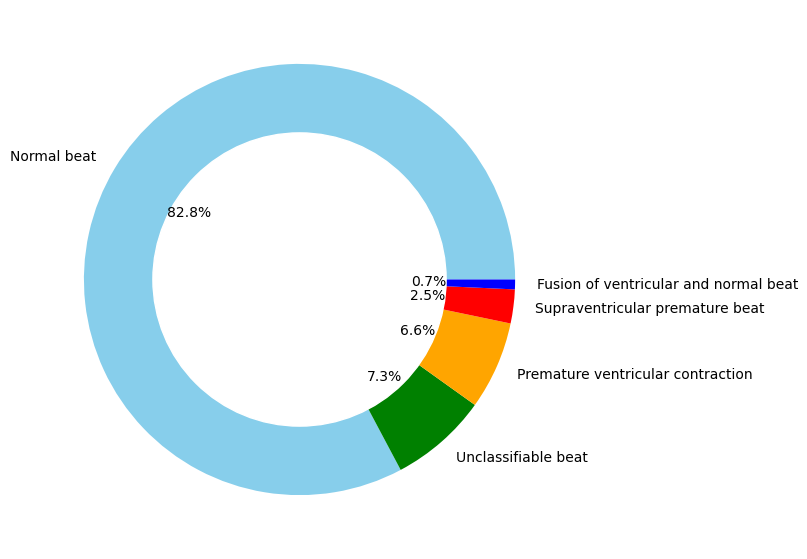

In [5]:
plt.figure(figsize=(14, 7))
pie_chart = plt.Circle((0, 0), 0.68, color='white')
values = df_train[187].value_counts()
plt.pie(values, labels=['Normal beat', 'Unclassifiable beat', 'Premature ventricular contraction', 'Supraventricular premature beat', 'Fusion of ventricular and normal beat'],
        colors=['skyblue', 'green', 'orange', 'red', 'blue'], autopct='%1.1f%%')
plot = plt.gcf()
plot.gca().add_artist(pie_chart)
plt.show()

The pie chart provides a clear visualization of the number of different types of beats. It highlights stark differences between each group, demonstrating that the dataset is unbalanced in terms of beat types. This imbalance should be taken into consideration during model training to **ensure better generalization**.

## Balancing Classes


To achieve class balance, three strategies can be employed :

1. **Undersampling:** This approach involves reducing the majority class, but it comes with the potential drawback of removing potentially significant data points.

2. **Oversampling:** This method involves duplicating or generating data from the minority class to increase its representation. Although it can effectively enhance the minority class's impact, it may lead to overfitting. Synthetic Minority Over-sampling Technique (SMOTE) is a popular method for handling imbalanced data, but it's not always the best choice.

3. **Combined undersampling and oversampling:** This approach amalgamates the previous two methods for a more balanced result.

For our specific case, I didn't apply the SMOTE technique due to its inefficiency with a high-dimensional dataset (187 features) and a large volume of records. Instead, I opted for the third approach, implementing a combination of undersampling for the class 0 and oversampling for other classes. Consequently, the final distribution across classes is not equal but is reasonably balanced, creating a more robust classification model.

In [ ]:
df_train_0 = df_train[df_train[187] == 0]
df_train_1 = df_train[df_train[187] == 1]
df_train_2 = df_train[df_train[187] == 2]
df_train_3 = df_train[df_train[187] == 3]
df_train_4 = df_train[df_train[187] == 4]

df_1_upsample = resample(df_train_1, n_samples = 10000, replace = True, random_state = 123)
df_2_upsample = resample(df_train_2, n_samples = 20000, replace = True, random_state = 123)
df_3_upsample = resample(df_train_3, n_samples = 6000, replace = True, random_state = 123)
df_4_upsample = resample(df_train_4, n_samples = 15000, replace = True, random_state = 123)
df_0_downsample = df_train_0.sample(n =30000, random_state=123)

df_train = pd.concat([df_0_downsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [ ]:
df_train.shape

(81000, 188)

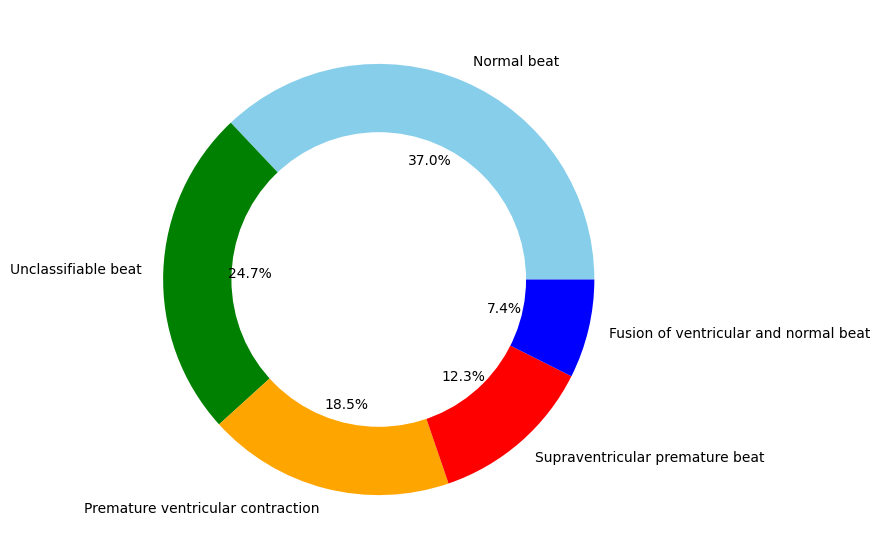

In [ ]:
plt.figure(figsize=(14, 7))
pie_chart = plt.Circle((0, 0), 0.68, color='white')
values = df_train[187].value_counts()
plt.pie(values, labels=['Normal beat', 'Unclassifiable beat', 'Premature ventricular contraction', 'Supraventricular premature beat', 'Fusion of ventricular and normal beat'],
        colors=['skyblue', 'green', 'orange', 'red', 'blue'], autopct='%1.1f%%')
plot = plt.gcf()
plot.gca().add_artist(pie_chart)
plt.show()

## hold-out Data set splitting

In this section, I allocate a portion of the training data to serve as a hold-out sample. This subset consists of **5%** of the overall training dataset.

Note that straficitaion should be considered to capture the distribution of each group in the hold-out sample.




In [ ]:
X_train = df_train.iloc[:, :-1]
y_train = df_train[187]


X_train, X_hold_out, y_train, y_hold_out = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)
df_train = pd.concat([X_train, y_train], axis=1)

print(X_hold_out.shape, y_hold_out.shape)
print(df_train.shape)

(4378, 187) (4378,)
(83176, 188)


In [ ]:
values = y_hold_out.value_counts()
values

0    3624
4     322
2     289
1     111
3      32
Name: 187, dtype: int64

**The sample represents all groups in itself.**

# Modeling

The initial step involves partitioning the training dataset into separate training and validation sets. The initial step involves partitioning the training dataset into separate training and validation sets. 

In [ ]:
# Shuffling data for out caoncate dataset
df_train = df_train.sample(frac=1, random_state=42)

X_train = df_train.iloc[:, :-1]
y_train = df_train[187]

# Split dataset (train & validation set)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

# Test data prepration
X_test = df_test.iloc[:, :-1]
y_test = df_test[187]

# Data sets size
print(f'Train set shape: X:{X_train.shape}, y:{y_train.shape}')
print(f'Validation set shape: X:{X_validation.shape}, y:{y_validation.shape}')
print(f'Test set shape: X:{X_test.shape}, y:{y_test.shape}')

Train set shape: X:(64800, 187), y:(64800,)
Validation set shape: X:(16200, 187), y:(16200,)
Test set shape: X:(21892, 187), y:(21892,)


## Deep Learning - CNN


For the modeling phase, I employed a ordinary Convolutional Neural Network (CNN) structure for the classification task. As demonstrated in the article, CNNs effectively capture dependencies between features, making them a fitting choice for this task. In light of computational constraints during training and hyperparameter tuning, I opted for a simplified version of the CNN structure.

Over time, I've implemented numerous deep learning models for tasks such as time-series forecasting and natural language processing, which can be explored on my GitHub profile (https://github.com/behdad13).

The proposed model comprises two convolutional layers, each followed by a Rectified Linear Unit (ReLU) activation function, a max pooling layer, and finally a fully connected layer, which classifies a given sample.

In [ ]:
# Data prepration for DL models
# Reshape to be [samples][time_steps][features]

X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_validation = X_validation.values.reshape(X_validation.shape[0], X_validation.shape[1])
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

print(f'shape: X_train--> {X_train.shape}, validation--> {X_validation.shape}')

shape: X_train--> (64800, 187, 1), validation--> (16200, 187, 1)


In [ ]:
# Convert labels to categorical one-hot encoding

y_train = keras.utils.to_categorical(y_train, num_classes=5)
y_validation = keras.utils.to_categorical(y_validation, num_classes=5)

print(f'shape: X_train--> {y_train.shape}, validation--> {y_validation.shape}')

shape: X_train--> (64800, 5), validation--> (16200, 5)


## Overfitting Problem

Overfitting occurs when a model becomes too complex and starts to memorize the training data instead of learning general patterns that can be applied to unseen data. To avoid **overfitting** during DL model training, I used two method:


1.   **Dropout:** Dropout is a regularization technique commonly used in DL models to prevent overfitting. In dropout, during the training process, a random fraction of the neurons in a layer are temporarily "dropped out" or set to zero. By randomly dropping out units, dropout prevents the neural network from relying too much on any particular set of units. It forces the network to learn redundant representations by spreading out the learning across different neurons.

2.   **Early Stopping:** Early stopping is a technique used in machine learning to prevent overfitting and improve model generalization by monitoring the performance of a model during training and stopping the training process when the performance on a validation set starts to deteriorate (increase in validation error). By monitoring a predefined metric, such as validation loss or accuracy, the training process can be halted early, saving time and computational resources, while still obtaining a model that performs well on unseen data.



## Hyperparameter Tuning with MLflow

In this segment, I utilized the MLFlow library for hyperparameter tuning of the proposed model. Given GPU constraints, I focused on a small yet crucial set of hyperparameters: kernel_sizes and filter_sizes. However, other hyperparameters such as dropout ratio, learning_rate, pool_size, batch_size, and the number of epochs could also be considered for further refinement.

Ideally, using a continuous range for hyperparameter tuning offers a more nuanced search compared to a discrete set of numbers, as it may capture optimal hyperparameters more accurately. Nonetheless, it's worth mentioning that tackling all hyperparameters simultaneously may complicate the search for optimal values. Therefore, it's advisable to start with a select group of hyperparameters and a narrower range, gradually expanding the scope based on model performance and computational feasibility.

In [ ]:
# Define the hyperparameter values 
filter_sizes = [64, 128]
kernel_sizes = [3, 5, 7]
pool_size = 2

mlflow.set_experiment("Hyperparameter_Tuning")

best_accuracy = 0.0
best_model_path = ""

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        with mlflow.start_run():
            model = Sequential()
            # CNN model
            model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(187,1)))
            model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
            model.add(Dropout(0.1)) 
            model.add(MaxPooling1D(pool_size=pool_size))
            # Output layer
            model.add(Flatten())
            model.add(Dense(100, activation='relu'))
            model.add(Dense(5, activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            early_stop = EarlyStopping(patience=3, monitor='val_loss', mode='min', verbose=1)

            model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_validation, y_validation), callbacks=[early_stop])

            loss, accuracy = model.evaluate(X_validation, y_validation)

            # Save the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_path = f"best_model_filter_{filter_size}_kernel_{kernel_size}_pool_{pool_size}.h5"
                save_model(model, best_model_path)

            mlflow.log_params({"filter_size": filter_size, "kernel_size": kernel_size, "pool_size": pool_size})
            mlflow.log_metrics({"accuracy": accuracy, "loss": loss})

print("Best model saved at:", best_model_path)

In [ ]:
## Fetch the best run based on the highest accuracy
best_run = mlflow.search_runs(order_by=['metrics.accuracy DESC']).iloc[0]

# Access the best hyperparameters and metrics
best_kernel_size = best_run['params.kernel_size']
best_pool_size = best_run['params.pool_size']
best_filter_size = best_run['params.filter_size']
best_accuracy = best_run['metrics.accuracy']

print("Best Hyperparameters:")
print("kernel_size:", best_kernel_size)
print("filter_size:", best_filter_size)
print("pool_size:", best_pool_size)
print("Best Accuracy:", round(best_accuracy, 4))

Best Hyperparameters:
kernel_size: 3
filter_size: 128
pool_size: 2
Best Accuracy: 0.9896


Here is the best set of hyper-parameters (it may be different from what you I implemented on my IDE)

In [ ]:
# List all runs
all_run = mlflow.search_runs()
all_run

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,metrics.loss,params.pool_size,params.filter_size,params.kernel_size,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,89845ce164a24e5db828b61ee0de0243,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/8984...,2023-05-29 23:33:57.379000+00:00,2023-05-30 00:03:46.621000+00:00,0.987840,0.040935,2,128,7,crawling-grouse-741,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL
1,40ddbed9bdad48bb8ed25aa4169501eb,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/40dd...,2023-05-29 23:09:24.233000+00:00,2023-05-29 23:33:57.377000+00:00,0.986667,0.045609,2,128,5,shivering-turtle-91,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL
2,e99ca681b5114393950c397354bea35e,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/e99c...,2023-05-29 22:50:12.598000+00:00,2023-05-29 23:09:24.230000+00:00,0.989568,0.038265,2,128,3,skillful-squid-621,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL
3,30852cae495c422db42f6f18f33fedcd,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/3085...,2023-05-29 22:39:25.489000+00:00,2023-05-29 22:50:12.593000+00:00,0.987531,0.042210,2,64,7,gifted-sponge-105,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL
4,632c12d90fa840e1a3cfbafba2520f45,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/632c...,2023-05-29 22:30:14.635000+00:00,2023-05-29 22:39:25.486000+00:00,0.985926,0.044865,2,64,5,unique-skink-112,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL
5,b2ca298201c94df79edc79e4689f04c5,839655448303180058,FINISHED,file:///content/mlruns/839655448303180058/b2ca...,2023-05-29 22:22:45.355000+00:00,2023-05-29 22:30:14.632000+00:00,0.984321,0.048385,2,64,3,sassy-robin-444,root,/usr/local/lib/python3.10/dist-packages/ipyker...,LOCAL


The table presented outlines the results from various runs. It reveals a positive correlation between filter size and validation accuracy: larger filter sizes yield better results.

To visually assess the hyperparameter tuning process, execute the following command:


```
# !mlflow ui
```


This command launches the MLFlow user interface, allowing you to interactively explore and compare the outcomes of your tuning job.


## Evaluation on test set

In [ ]:
# Load the saved model

loaded_model = load_model(best_model_path)

X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test_one = keras.utils.to_categorical(y_test, num_classes=5)

loss, accuracy = loaded_model.evaluate(X_test, y_test_one)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

685/685 [==============================] - 9s 13ms/step - loss: 0.1222 - accuracy: 0.9771
Test Loss: 0.12219521403312683
Test Accuracy: 0.9770692586898804


In [ ]:
# Provide classification report

y_pred = loaded_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

print(classification_report(y_test,y_pred_classes))

685/685 [==============================] - 9s 13ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.73      0.80      0.76       556
         2.0       0.94      0.95      0.94      1448
         3.0       0.76      0.75      0.76       162
         4.0       0.99      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.88      0.89      0.89     21892
weighted avg       0.98      0.98      0.98     21892



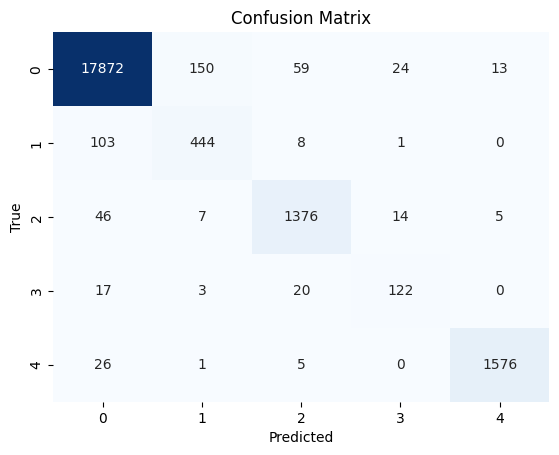

In [ ]:
# Provide Confusion matrix

cm = confusion_matrix(y_test, y_pred_classes)
num_classes = len(np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(range(num_classes))
ax.yaxis.set_ticklabels(range(num_classes))
plt.show()


The overall accuracy of our model approximates 98%, which aligns closely with the accuracy achieved during the training process. This suggests that my model has been effectively generalized.

However, it's crucial to acknowledge that recall is another key metric in evaluating model performance, particularly because it concentrates on reducing type II errors (False Negatives). The emphasis on minimizing False Negatives arises from the serious implications of incorrectly classifying patients as healthy when they are not.

The classification report reveals a reasonable recall score across all classes, indicating that my model performs well in this regard.

# Hold-out Testing

In [ ]:
X_hold_out = X_hold_out.values.reshape(X_hold_out.shape[0], X_hold_out.shape[1])
X_hold_out = np.reshape(X_hold_out, (X_hold_out.shape[0], X_hold_out.shape[1], 1))
y_test_hold_out_one = keras.utils.to_categorical(y_hold_out, num_classes=5)

loss, accuracy = loaded_model.evaluate(X_hold_out, y_test_hold_out_one)

y_pred_hold_out = loaded_model.predict(X_hold_out)
y_pred_classes_hold_out = y_pred_hold_out.argmax(axis=-1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print(classification_report(y_hold_out,y_pred_classes_hold_out))

137/137 [==============================] - 2s 13ms/step
Test Loss: 0.10144563764333725
Test Accuracy: 0.9746459722518921
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3624
           1       0.68      0.77      0.72       111
           2       0.93      0.96      0.95       289
           3       0.76      0.78      0.77        32
           4       0.98      0.99      0.99       322

    accuracy                           0.97      4378
   macro avg       0.87      0.90      0.88      4378
weighted avg       0.98      0.97      0.98      4378



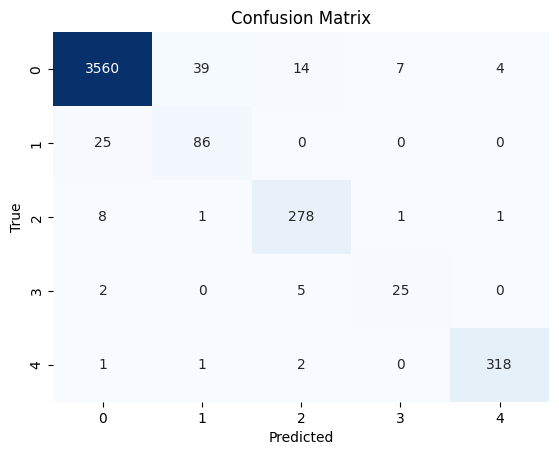

In [ ]:
cm = confusion_matrix(y_hold_out,y_pred_classes_hold_out)
num_classes = len(np.unique(y_hold_out))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(range(num_classes))
ax.yaxis.set_ticklabels(range(num_classes))
plt.show()


The consistency in recall and overall accuracy between the validation, test, and hold-out set results reaffirms the model's robust generalization. This confirms that our model maintains its performance when applied to new, unseen data.

# Deployment Strategy

To create a production-ready solution for deploying the model, I propose the following strategy with 3 steps:

1. Step 1: **Develop a Flask application:** 

Initially, I suggest deploying the model using a Flask application. This involves setting up a server locally to host the model. The accompanying image illustrates the deployed model on my local server. The application accepts a .csv file containing a record of ECG signals as input and generates the respective signal type as output.


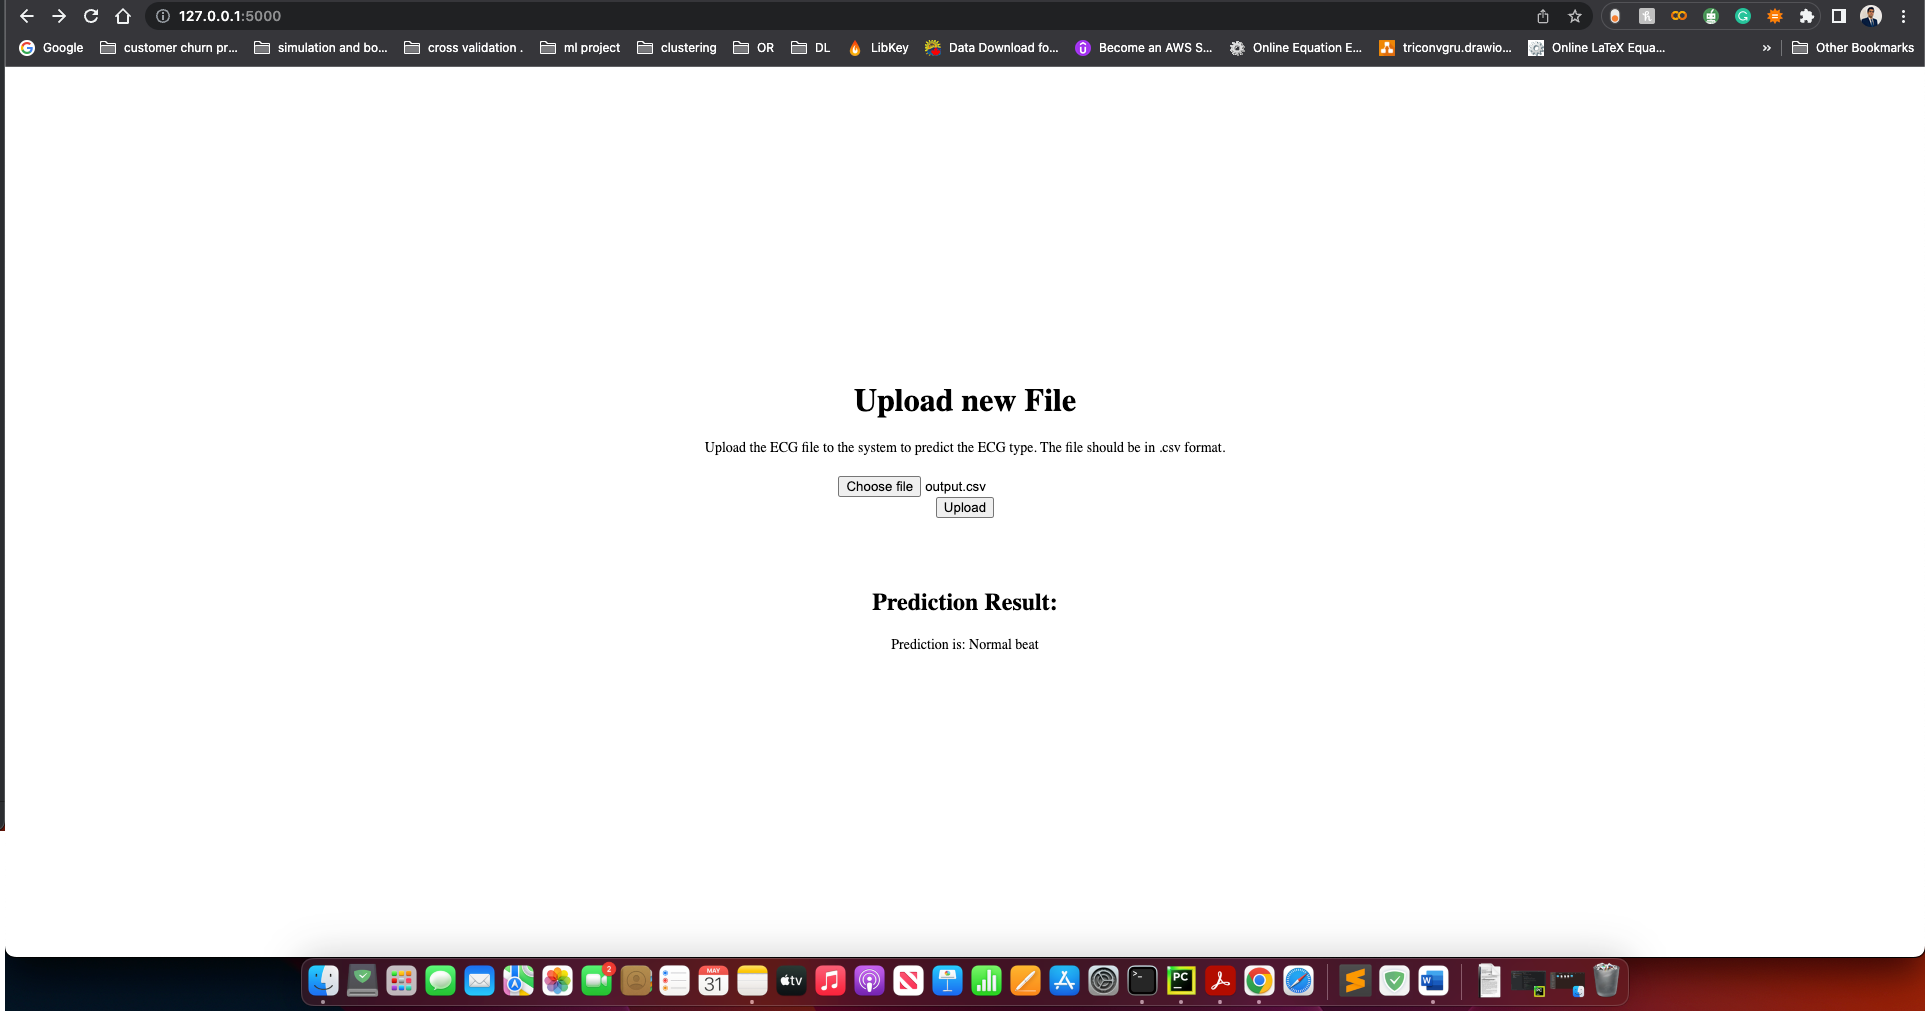




2. Step 2: **Dockerizing the Flask Application**

As mentioned before, the flask app is not good on it self because of limited and manual scalability and local environmnt. In order to solve the problem, Docker should be used first. Docker is a containerization platform which allows developers to package applications with their necessary components, and ship them all out as one package. This ensures that the application works uniformly across **different computing environments**. The steps includes 1. Build a Dockerfile 2. Build Docker Image 3. Run Docker container.

3. Step 3: **Deploying with Kubernetes**

Kubernetes is a container orchestration platform that provides mechanisms for deploying, maintaining, and **scaling** applications. By deploying the Flask application on Kubernetes, we can take advantage of its **auto-scaling capabilities**, **load balancing**, and ensure **high availability**. One of the key features of Kubernetes is its ability to replicate images across multiple pods. This replication ensures high availability and fault tolerance by distributing the workload across multiple instances of the same containerized application. By replicating the images, Kubernetes ensures that if one pod fails or becomes unresponsive, another pod with the same image is available to handle the requests. 

-------------------

**Considerations and Challenges**

1. **Model Versioning:** As we continue to train and improve your model, we need a mechanism to manage different versions of your model and switch between them easily.

2. **Data and Feature Versioning:** Similarly, changes to our data features can affect model performance. we need to track these changes alongside our model versioning.

3. **Monitoring and Logging:** our deployment should include robust logging and monitoring. This will help us understand how our model is performing in production and quickly identify any issues and problems.

-------------------

**Handle model versioning**

When it comes to model versioning during model deployment , it is essential to keep track of different versions to ensure **reproducibility**, **traceability**, and **easy rollback** if necessary. 

Semantic versioning is an essential practice in model deployment. By following a semantic versioning scheme (**MAJOR.MINOR.PATCH**), you can indicate different versions of the model (major change). Incrementing the MAJOR version illustrates significant changes that are not backward compatible, while the MINOR version represents backward-compatible additions or enhancements. The PATCH version is used for backward-compatible bug fixes. To effectively manage versioning, we can utilize a version control system such as **Git**. This allows us to track changes in your model code, configuration files, and associated assets. 

-------------------



**handle monitoring**

For handeling monitoring during model deployment, I propose to use Elasticsearch and Prometheus.

1. **Elasticsearch & Kibana**: 

For monitoring during model deployment, Elasticsearch can be utilized to store logs and metrics generated by the deployed model. You can send logs and metrics to Elasticsearch with the Logstash tool. By incorporating Elasticsearch with Kibana, you gain access to a powerful dashboard that facilitates visualization and analysis of log data. Additionally, Elasticsearch can be configured to send notifications or alerts when sudden changes or anomalies occur, enabling proactive monitoring and timely response to potential issues.


2. **Prometheus**

Prometheus is specifically designed for monitoring highly dynamic and containerized environments. While Elasticsearch is well-suited for monitoring logs and metrics of the deployed model, Prometheus serves as a comprehensive monitoring solution for both applications and infrastructure. It acts as a powerful umbrella that covers a **broader range of services and infrastructure**, enabling you to monitor not just the model itself but also the health and performance of the entire system.

For instance, if a Docker container hosting your model fails unexpectedly, Elasticsearch may not capture any logs for that particular failure. However, Prometheus excels at detecting system failures and can provide visibility into the overall health of the deployed infrastructure. By leveraging Prometheus, you can proactively monitor and identify issues in the system, ensuring the smooth operation of your model deployment.

-------------------


**Best Practice**

Aside from all methods described previosuly that are standard deployment, I proposed an autoimatice deployment strategy called 
**Continuous Integration/Continuous Deployment (CI/CD)**. The method is designed to automate the deployment of models, making it easier, faster, and more reliable.

CI/CD involves automating the stages of data preprocessing, model training, validation, and deployment. Each time there is a change in the data, model architecture, or hyperparameters, the model is retrained and validated. If it passes predefined performance metrics, it is automatically deployed in the production environment. In addition, CI/CD in ML/DL allows for **model versioning and automatic rollback** if the newly deployed model is underperforming. 

Note that we can use GitLab which is a powerful platform that can be used for Continuous Integration/Continuous Deployment (CI/CD) in our DL project. 



